In [1]:
import random
import numpy as np

from typing import List, Tuple
from scipy import stats
from scipy.linalg import solve
from functools import lru_cache

def create_comparison_set(N_cand:int, N_comp:int=None, N_total_comp:int=None):
    # set (num comparisons per item) or (num total comparisons)
    if N_comp: 
        assert (N_comp < N_cand) and (N_comp*N_cand%2==0)
        N_total_comp = N_comp*N_cand/2
        
    elif N_total_comp: 
        assert N_total_comp <= N_cand*(N_cand-1)/2
        N_comp=N_cand-1
        
    # begin search for valid set of pairs
    pairs = {k:[] for k in range(N_cand)}
    pairs_made = 0
    while pairs_made < N_total_comp:  
        i, j = None, None
        
        possible_i = [x for x in range(N_cand) if len(pairs[x])<N_comp]
        i = random.choice(possible_i)
        possible_j = [x for x in range(N_cand) if (x!=i) and (x not in pairs[i]) and (len(pairs[x])<N_comp)]

        if possible_j == []:
            possible_j = [x for x in range(N_cand) if (x!=i) and (x not in pairs[i])]
            j = random.choice(possible_j)
            i_del = random.choice(pairs[j])
            
            pairs[i_del].remove(j)
            pairs[j].remove(i_del)
            pairs_made -= 1
        else:
            j = random.choice(possible_j)
            
        # if at this stage, we can compare i and j
        pairs[i].append(j)
        pairs[j].append(i)
        pairs_made += 1

    comparisons = set([(i, j) for i in pairs for j in pairs[i] if i<j])
    return sorted(comparisons)

def order_comparisons(comparisons:List[Tuple[int]], ordering:str='random'):   
    """ unfinished """
    if ordering == 'random':
        comparisons = [tuple(random.sample(x, len(x))) for x in comparisons]
    elif ordering == 'symmetric':
        comparisons = comparisons + [(j,i) for (i,j) in comparisons]
    elif ordering == 'balanced':
        N_cand = max([x[1] for x in comparisons])+1
        N_comp = len(comparisons)/N_cand
        outputs = {k:[] for k in range(N_cand)}
        
        for (i, j) in comparisons:
            if random.randint(0,1) == 1:
                x, y = i, j
            else:
                y, x = i, j
                
            if len(outputs[x]) < N_comp:
                outputs[x].append(y)
            elif len(outputs[y]) < N_comp:
                outputs[y].append(x)
            else:
                print(i,j)
                print(outputs)
                raise ValueError('damn man')
        
        comparisons = set([(i, j) for i in pairs for j in pairs[i]])
    return comparisons

def win_ratio(C, M):    
    n = C.shape[0] 
    x = np.sum(C, axis=1)/np.sum(M, axis=1)
    return x

def colley_scoring(C, M):    
    n = C.shape[0]
    B = 2 * np.eye(n) + np.diag(np.sum(M, axis=0)) - M
    b = 1 + 0.5*(np.sum(C, axis=1)-np.sum(C, axis=0)) 
    x = solve(B, b)
    return x

def modelling(comparisons:List[Tuple[int]], bias:float=0, noise:float=0, scoring:str='colley'):
    N_cand = max([x[1] for x in comparisons] + [x[0] for x in comparisons])+1
    true_scores = np.random.randn(N_cand)
    
    # create matrix of true labels
    mask_matrix = np.zeros((N_cand, N_cand))
    for (i, j) in comparisons:
        mask_matrix[i,j] += 1
        mask_matrix[j,i] += 1

    # create simulated comparison results
    comp_matrix = np.zeros((N_cand, N_cand))
    for (i, j) in comparisons:
        score_i, score_j = true_scores[i], true_scores[j]
        if score_i - score_j > bias + noise*np.random.randn():
            comp_matrix[i,j] += 1
        else:
            comp_matrix[j,i] += 1
    
    return comp_matrix, mask_matrix, true_scores
    
def true_scores_to_matrix(true_scores):
    N_cand = len(true_scores)
    label_matrix = np.zeros((N_cand, N_cand))
    for i in range(N_cand):
        for j in range(N_cand):
            if true_scores[i] > true_scores[j]:
                label_matrix[i][j] += 1
    return label_matrix

def run_modelling(comparisons:List[Tuple[int]], bias:float=0, noise:float=0, scoring:str='colley'):
    comp_matrix, mask_matrix, true_scores = modelling(comparisons=comparisons, bias=bias, noise=noise, scoring=scoring)
    
    if scoring == 'colley':
        scores = colley_scoring(comp_matrix, mask_matrix)
    elif scoring == 'win-ratio':
        scores = win_ratio(comp_matrix, mask_matrix)

    # Find spearman ranks
    spearman = stats.spearmanr(scores, true_scores)[0]
    return spearman

@lru_cache(maxsize=10000)
def simulation(num_draws:int, N_cand:int=None, N_total_comp:int=None, N_comp:int=None, bias:float=0, noise:float=0, ordering:str='random', scoring:str='colley'):
    scores = []
    for _ in range(num_draws):
        comparisons = create_comparison_set(N_cand=N_cand, N_total_comp=N_total_comp, N_comp=N_comp)
        comparisons = order_comparisons(comparisons, ordering=ordering)
        spear = run_modelling(comparisons, bias=bias, noise=noise)
        
        if not np.isnan(spear):
            scores.append(spear)

    return np.mean(scores), np.std(scores)

# simulation(
#     num_draws=200, 
#     N_cand=16,
#     N_comp=5,
#     bias=0.2,
#     noise=0
# )

In [2]:
import matplotlib.pyplot as plt
from functools import lru_cache
from tqdm import tqdm

def influence_of_N_comp(N_cand, ordering='random', scoring='colley', balanced=True):
    output = []
    for N_comp in tqdm(range(1,N_cand)):
        N_total_comp = None
        if not balanced:
            N_total_comp = N_cand*N_comp/2
            N_comp=None
            
        output.append(
            simulation(
                num_draws=1000, 
                N_cand=N_cand,
                N_total_comp=N_total_comp,
                N_comp=N_comp,
                bias=0,
                noise=0,
                ordering=ordering,
                scoring=scoring
            )
        )
    return output

100%|███████████████████████████████████████████| 15/15 [00:24<00:00,  1.65s/it]


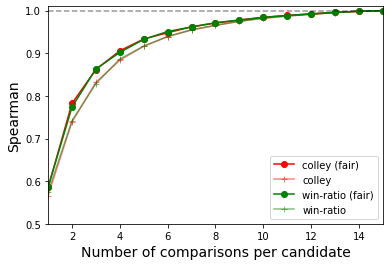

In [3]:
for scoring in ['colley', 'win-ratio']:
    color = 'red' if scoring == 'colley' else 'green'
    for balanced in [True, False]:
        alpha = 1 if balanced else 0.5
        marker = 'o' if balanced else '+'
        label = f"{scoring} (fair)" if balanced else f"{scoring}"
        output = influence_of_N_comp(N_cand=16, scoring=scoring, balanced=balanced)
        plt.plot(range(1,16), list(zip(*output))[0], marker=marker, color=color, alpha=alpha, label=label)

plt.xlabel('Number of comparisons per candidate', size=14)
plt.ylabel('Spearman', size=14)
plt.legend()
plt.xlim(1,15)
plt.ylim(0.5,1.01)
plt.axhline(1, color='k', linestyle='--', alpha=0.4)

In [4]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def impact_of_bias(N_cand, N_comp, noise:float=0, ordering='random'):
    output = []

    for bias in list(np.arange(0,2.1,0.2)):
        output.append(
            simulation(
                num_draws=1000,
                N_cand=N_cand,
                N_comp=N_comp,
                bias=bias,
                noise=noise,
                ordering=ordering,
                scoring='colley'
            )
        )
    return output


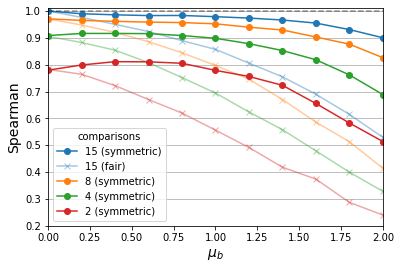

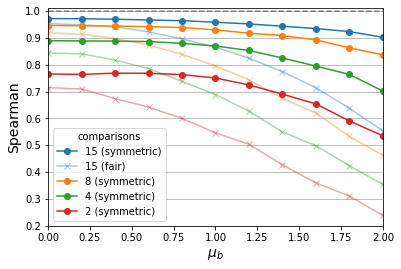

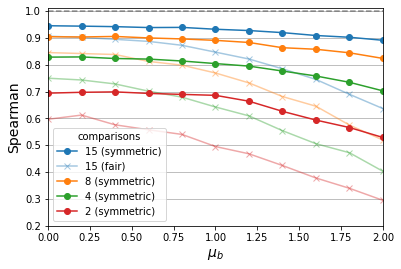

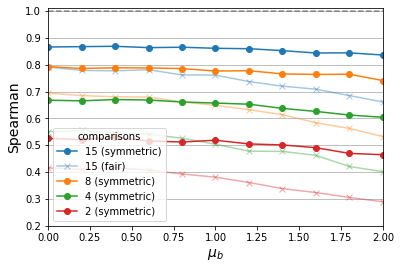

In [12]:
import itertools

for noise in [0,0.5,1,2]:
    for N_comp in [15,8,4,2]:
        # plot symmetric
        output = impact_of_bias(N_cand=16, N_comp=N_comp, noise=noise, ordering='symmetric')
        plt.plot(np.arange(0,2.1,0.2), list(zip(*output))[0], marker='o', label=f"{N_comp} (symmetric)")

        # plot random samples
        c = plt.gca().lines[-1].get_color()
        output = impact_of_bias(N_cand=16, N_comp=N_comp, noise=noise)
        #"
        if N_comp==15:
            plt.plot(np.arange(0,2.1,0.2), list(zip(*output))[0], marker='x', label=f"{N_comp} (fair)", color=c, alpha=0.4)
        else:
            plt.plot(np.arange(0,2.1,0.2), list(zip(*output))[0], marker='x', color=c, alpha=0.4)

    plt.xlabel(r'$\mu_b$', size=14)
    plt.ylabel('Spearman', size=14)
    plt.legend(title="comparisons")
    
    plt.xlim(0,2)
    plt.ylim(0.2,1.01)
    plt.axhline(1, color='k', linestyle='--', alpha=0.4)
    plt.grid(axis = 'y')
    plt.show()
    

In [58]:
import time

for _ in range(100):
    comparisons = create_comparison_set(N_cand=16, N_comp=2)
    #comparisons = order_comparisons(comparisons, ordering='random')
    comp_matrix, mask_matrix, true_scores = modelling(comparisons=comparisons)
    label_matrix = true_scores_to_matrix(true_scores)
    
    scores = colley_scoring(comp_matrix, mask_matrix)
        
    #create mask to ignore diagonal
    mask = np.ones((16,16)) - np.eye(16)
    mask = mask*mask_matrix
    acc = np.mean((comp_matrix == label_matrix)[mask==1])
    print(acc)
    
    #bias
    bias = np.tril(comp_matrix)
    
    time.sleep(1)

1.0
1.0
1.0
1.0
1.0


KeyboardInterrupt: 

In [50]:
label_matrix

array([[0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.,

In [51]:
comp_matrix

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,

In [22]:
print([int(100*i) for i in true_scores])
label_matrix = true_scores_to_matrix(true_scores)
print(label_matrix)



[27, -74, 60, -81, -21, -70, 74, 6, -65, -1, 9, 114, -167, 151, 217, 121]
[[0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]]


In [24]:
comp_matrix

array([[0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,

In [5]:
def true_scores_to_matrix(true_scores):
    N_cand = len(true_scores)
    label_matrix = np.zeros((N_cand, N_cand))
    for i in range(N_cand):
        for j in range(N_cand):
            if true_scores[i] > true_scores[j]:
                label_matrix[i][j] += 1
    return label_matrix


In [ ]:
label_matrix = true_scores_to_matrix(true_scores)

In [ ]:
comparisons = create_comparison_set(10, 4)
comparisons = order_comparisons(comparisons, ordering='random')

In [ ]:
outputs = {}

N_cand=16
N_comp=4
ordering='random'

for bias in [0,0.1,0.2,0.3,0.5,0.7,1.0]:
    print(bias)
    output = []
    for noise in np.arange(0,2,0.1):
        output.append(
            simulation(
                num_draws=1000, 
                N_cand=N_cand,
                N_comp=N_comp,
                bias=bias,
                noise=noise,
                ordering=ordering
            )
        )
    outputs[bias] = output


In [ ]:
import matplotlib.pyplot as plt

for k, v in outputs.items():
    plt.plot(np.arange(0,2,0.1), list(zip(*v))[0], label=k)
plt.legend()

In [ ]:
len(output)

In [ ]:
import numpy as np
from scipy.optimize import minimize


def consistency_cost_func(x, c_matrix):
    n = len(x)
    s = 0

    for i in range(n):
        for j in range(n):
            if c_matrix[i, j] == 1:
                s += x[i] > x[j]
            elif c_matrix[i, j] == 0:
                s += x[i] < x[j]
    return s

def optimize_ranks(c_matrix, m_matrix):
    n = c_matrix.shape[0]
    x0 = np.zeros(n)

    def cost_func(x):
        return -consistency_cost_func(x, c_matrix)

    bounds = [(0, 1) for _ in range(n)]

    constraints = []
    for i in range(n):
        for j in range(n):
            if m_matrix[i, j] == 0:
                constraints.append({'type': 'ineq', 'fun': lambda x: x[j] - x[i]})

    result = minimize(cost_func, x0, method='SLSQP', bounds=bounds, constraints=tuple(constraints))
    return result.x

In [ ]:
def modelling(comparisons:List[Tuple[int]], bias:float=0, noise:float=0):
    N_cand = max([x[1] for x in comparisons] + [x[0] for x in comparisons])+1
    true_scores = np.random.randn(N_cand)
    
    # create matrix of true labels
    label_matrix = np.zeros((N_cand, N_cand))
    for (i, j) in comparisons:
        score_i, score_j = true_scores[i], true_scores[j]
        if score_i - score_j > 0:
            label_matrix[i,j] += 1
        else:
            label_matrix[j,i] += 1
    
    # create simulated comparison results
    comp_matrix = np.zeros((N_cand, N_cand))
    for (i, j) in comparisons:
        score_i, score_j = true_scores[i], true_scores[j]
        if score_i - score_j > bias + noise*np.random.randn():
            comp_matrix[i,j] += 1
        else:
            comp_matrix[j,i] += 1
    
    return comp_matrix, true_scores
    

In [ ]:
comparisons = create_comparison_set(N_cand=16, N_comp=5)
comparisons = order_comparisons(comparisons, ordering='random')

comp_matrix, true_scores = modelling(comparisons, noise=1)
mask_matrix = np.zeros((16, 16))

for (i, j) in comparisons:
    mask_matrix[i,j] += 1
    mask_matrix[j,i] += 1

In [ ]:
import numpy as np
from scipy.linalg import solve

def win_ratio(C, M):    
    n = C.shape[0]  # Number of teams
    
    # Solve for x in Bx = b using a linear solver.
    x = np.sum(C, axis=1)/np.sum(M, axis=1)

    # Return the team ratings.
    return x

def colley_ranking(C, M):    
    n = C.shape[0]  # Number of teams
    B = 2 * np.eye(n) + np.diag(np.sum(M, axis=0)) - M
    b = 1 + 0.5*(np.sum(C, axis=1)-np.sum(C, axis=0)) 
    x = solve(B, b)
    return x

a = [float(i) for i in win_ratio(comp_matrix, mask_matrix)]
print(a)

colley_ranking(comp_matrix, mask_matrix)

b = [float(i) for i in colley_ranking(comp_matrix, mask_matrix)]
print(b)


In [ ]:
import numpy as np
from scipy.optimize import minimize

def consistency_cost_func(x, c_matrix):
    n = len(x)
    s = 0

    for i in range(n):
        for j in range(n):
            if c_matrix[i, j] == 1:
                s += x[i] > x[j]
            elif c_matrix[i, j] == 0:
                s += x[i] < x[j]
    return s

def optimize_ranks(c_matrix, m_matrix):
    n = c_matrix.shape[0]
    x0 = np.zeros(n)

    def cost_func(x):
        return -consistency_cost_func(x, c_matrix)

    bounds = [(0, 1) for _ in range(n)]

    constraints = []
    for i in range(n):
        for j in range(n):
            if m_matrix[i, j] == 0:
                constraints.append({'type': 'ineq', 'fun': lambda x: x[j] - x[i]})

    result = minimize(cost_func, x0, method='SLSQP', bounds=bounds, constraints=tuple(constraints))
    return result.x

optimize_ranks(comp_matrix, mask_matrix)

In [ ]:
mask_matrix

In [ ]:
mask_matrix